# Sparse Cannonical Correlation Analysis
This is the analysis pipline of the Sparse Cannonical Correlation Analysis paper in preperation. 

## Resting state data
---
We collected 165 subjects with 

i) resting state data

ii) mind wandering reports

iii) 20 something behavioural measures

### Resting state parameters
TR: 3s, TE: minimum full, No. of volumes: 180, Duration: 9 min, Flip angle: 90°, Voxel size: 3x3x3 mm, Matrix size: 64x64 -> FOV: 192x192mm, No of slices: 60, Slice acquisition: bottom-up interleaved

FSL version 4.1.9

### Preprocessing applied
i) Motion correction using MCFLIRT

ii) Slice-timing correction using Fourier-space time-series phase-shifting

iii) Highpass temporal filtering (Gaussian-weighted least-squares straight line fitting, with sigma=100.0s)

iv) Gaussian lowpass temporal filtering, with sigma=2.8s

v) 6 motion parameters (as estimated by MCFLIRT) regressed out

vi) CSF and WM signal regressed out (top 5 PCA components, CompCor method)

vii) Linear transformation to MNI152 2mm standard space

No spatial smoothing

No global signal regression

### Default mode network ROIs
We used a set of masks provided by Danilo Bzdok. 

@ Rocco - I need your help to update the properties of these bad boys.

### Creating correlation coefficeient for the selected ROI
See script: 
https://github.com/htwangtw/mindwanderinglabYork/blob/master/Project_SCCA/prepare_ImagingData.py

## Behavioural data - mind wandering reports
---
In a n-back task (see my repository: MindWanderingTask), we randomly probed the participants with a set of questions. They rated their thoughts on these different dimensions. 

In this analysis, we averaged the reports of each participant and then transformed into z score. See script: 
https://github.com/htwangtw/mindwanderinglabYork/blob/master/Project_SCCA/prepare_BehaveourData.py

## Behavioural data - cognitive measures
---


In [75]:
n_areas = 14
n_components = 6
pen_brain = 0.3
pen_behave = 0.5
region_labels_fn = 'C:\\Users\\Hao-Ting\\Documents\\Work\\Project_CCA\\sourcedata\\data_cross_corr_Bzdok_DMN14_ROIS.npy'
beh_keysfn = 'C:\\Users\\Hao-Ting\\Documents\\Work\\Project_CCA\\sourcedata\\data_raw_keys_MWQ_master.npy'

# behavefn = 'C:\\Users\\Hao-Ting\\Documents\\Work\\Project_CCA\\sourcedata\\data_MWQ_session_preprocessed.npy'
# rscorrfn = 'C:\\Users\\Hao-Ting\\Documents\\Work\\Project_CCA\\sourcedata\\data_cross_corr_Bzdok_DMN14_preprocessed.npy'
behavefn = 'C:\\Users\\Hao-Ting\\Documents\\Work\\Project_CCA\\sourcedata\\Y_SCCAraw.npy'
rscorrfn = 'C:\\Users\\Hao-Ting\\Documents\\Work\\Project_CCA\\sourcedata\\X_SCCAraw.npy'

In [76]:
from os.path import expanduser
import numpy as np

region_labels = np.load(expanduser(region_labels_fn))
beh_keys = np.load(expanduser(beh_keysfn))[1:]
penalty = (pen_brain,pen_behave)

# The behavioural and imaging data has already been preprocessed

# behavioral_data = np.load(expanduser(behavefn))
# rest_data = np.load(expanduser(rscorrfn))
# subject_subset = behavioral_data[:, 0].astype('i4') - 1

# X = rest_data[subject_subset,:]
# Y = behavioral_data[:,40:]

Y = np.load(expanduser(behavefn))
X = np.load(expanduser(rscorrfn))

In [77]:
import readline
import rpy2.rinterface as ri
import pandas as pd
import pandas.rpy.common as com
# load the Stanford package for SCCA
com.r(
'''
library(plyr)
library(impute)
library(Rcpp)
library(PMA)
''')

def SCCA_r(X,Y, n_components, pen):
    df_X = pd.DataFrame(X)
    df_Y = pd.DataFrame(Y)

    rmat_X = com.convert_to_r_matrix(df_X)
    rmat_Y = com.convert_to_r_matrix(df_Y)

    ri.globalenv['X'] = rmat_X
    ri.globalenv['Y'] = rmat_Y

    com.r(
        """
        out <- CCA(x = X, z = Y, K = %i, niter = 100, standardize = FALSE,
                   penaltyx = %f, penaltyz = %f)
        """ % (n_components, pen[0], pen[1]))

    # convert the results back to dataframes and then to numpy arrays
    df_u = com.convert_robj(com.r('out[1]'))['u']
    df_v = com.convert_robj(com.r('out[2]'))['v']
    cors = com.convert_robj(com.r('out[16]'))['cors'] #canonical correlation

    x_loadings = df_u.as_matrix()
    y_loadings = df_v.as_matrix()
    cors = np.array(cors)

    loadings = (x_loadings, y_loadings)

    pout = com.convert_robj(com.r('out'))
    
    return loadings, cors, pout

In [140]:
pen = penalty
df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y)

rmat_X = com.convert_to_r_matrix(df_X)
rmat_Y = com.convert_to_r_matrix(df_Y)

ri.globalenv['X'] = rmat_X
ri.globalenv['Y'] = rmat_Y

com.r(
    """
    out <- CCA(x = X, z = Y, K = %i, niter = 100, standardize = FALSE,
               penaltyx = %f, penaltyz = %f)
               
    names(out)
    
    """ % (n_components, pen[0], pen[1]))


# com.r(
#     '''
#     print(out)
#     ''')


# convert the results back to dataframes and then to numpy arrays
df_u = com.convert_robj(com.r('out[1]'))['u']
df_v = com.convert_robj(com.r('out[2]'))['v']
# cors = com.convert_robj(com.r('out[16]'))['cors'] #canonical correlation

print(com.convert_robj(com.r('out[11]')))


# x_loadings = df_u.as_matrix()
# y_loadings = df_v.as_matrix()
# cors = np.array(cors)

# loadings = (x_loadings, y_loadings)


RRuntimeError: Error in sort.list(y) : 'x' must be atomic for 'sort.list'
Have you called 'sort' on a list?


In [31]:
print loadings[0].shape
print loadings[1].shape
print np.dot(loadings[0].T,loadings[0])
print loadings[0]
print loadings[1]

(91L, 6L)
(13L, 6L)
[[  1.000e+00   2.177e-01   3.976e-04   1.278e-02   2.890e-01   6.555e-03]
 [  2.177e-01   1.000e+00   6.083e-02   3.093e-03   1.368e-02   7.242e-02]
 [  3.976e-04   6.083e-02   1.000e+00   1.651e-01  -1.974e-02   0.000e+00]
 [  1.278e-02   3.093e-03   1.651e-01   1.000e+00   0.000e+00   4.595e-02]
 [  2.890e-01   1.368e-02  -1.974e-02   0.000e+00   1.000e+00  -2.441e-02]
 [  6.555e-03   7.242e-02   0.000e+00   4.595e-02  -2.441e-02   1.000e+00]]
[[-0.     0.     0.    -0.     0.    -0.   ]
 [ 0.     0.    -0.     0.    -0.     0.   ]
 [ 0.018  0.     0.     0.601  0.    -0.   ]
 [-0.194 -0.008 -0.    -0.    -0.184 -0.   ]
 [-0.    -0.    -0.    -0.095 -0.    -0.139]
 [-0.    -0.    -0.    -0.    -0.    -0.   ]
 [-0.     0.     0.    -0.    -0.    -0.   ]
 [-0.    -0.     0.    -0.    -0.    -0.   ]
 [-0.    -0.     0.    -0.    -0.    -0.   ]
 [-0.    -0.     0.    -0.    -0.    -0.   ]
 [ 0.    -0.    -0.     0.    -0.173  0.   ]
 [ 0.     0.     0.     0.    -0. 

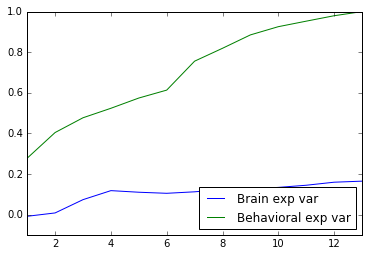

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.linear_model import LinearRegression
limit_exp_var = len(beh_keys) #save for later
exp_var_X = []
exp_var_Y = []
for i in range(1, limit_exp_var+1):
    n_com = i
    loadings, cors= SCCA_r(X,Y, n_com, penalty)

    P = loadings[0]
    lr = LinearRegression(fit_intercept=False)
    lr.fit(P, X.T)
    rec_X = lr.coef_.dot(P.T)
    exp_var_X.append(1 - (np.var(X - rec_X) / np.var(X)))

    Q = loadings[1]
    lr = LinearRegression(fit_intercept=False)
    lr.fit(Q, Y.T)
    rec_Y = lr.coef_.dot(Q.T)
    exp_var_Y.append(1 - np.var(Y - rec_Y) / np.var(Y))


plt.close('all')
plt.figure()
plt.plot(np.arange(limit_exp_var) + 1, exp_var_X, label='Brain exp var')
plt.plot(np.arange(limit_exp_var) + 1, exp_var_Y, label='Behavioral exp var')
plt.ylim(-0.1, 1)
plt.xlim(1, limit_exp_var)
plt.legend(loc='lower right')

In [70]:
loadings, corr, pout = SCCA_r(X, Y, n_components, penalty)

# x_loadings = loadings[0]
# y_loadings = loadings[1]

RRuntimeError: Error in sort.list(y) : 'x' must be atomic for 'sort.list'
Have you called 'sort' on a list?


In [34]:
np.dot(X, loadings[0][:,0])

(157L,)

In [51]:
np.corrcoef(np.dot(X,loadings[0]).T,np.dot(Y,loadings[1]).T).shape
lhs=np.dot(X,loadings[0])
rhs=np.dot(Y,loadings[1])

In [66]:
(np.corrcoef(lhs.T,rhs.T)[6:12,0:6])

array([[ 0.308,  0.188,  0.035,  0.231,  0.183,  0.211],
       [ 0.175,  0.353,  0.057, -0.01 ,  0.293,  0.182],
       [ 0.093,  0.161,  0.357,  0.235,  0.042,  0.044],
       [ 0.263,  0.108,  0.064,  0.308,  0.105,  0.154],
       [ 0.181,  0.324,  0.032, -0.071,  0.366,  0.216],
       [ 0.324,  0.221,  0.023,  0.187,  0.231,  0.243]])

In [42]:
x = np.array(0)
x.diagonal

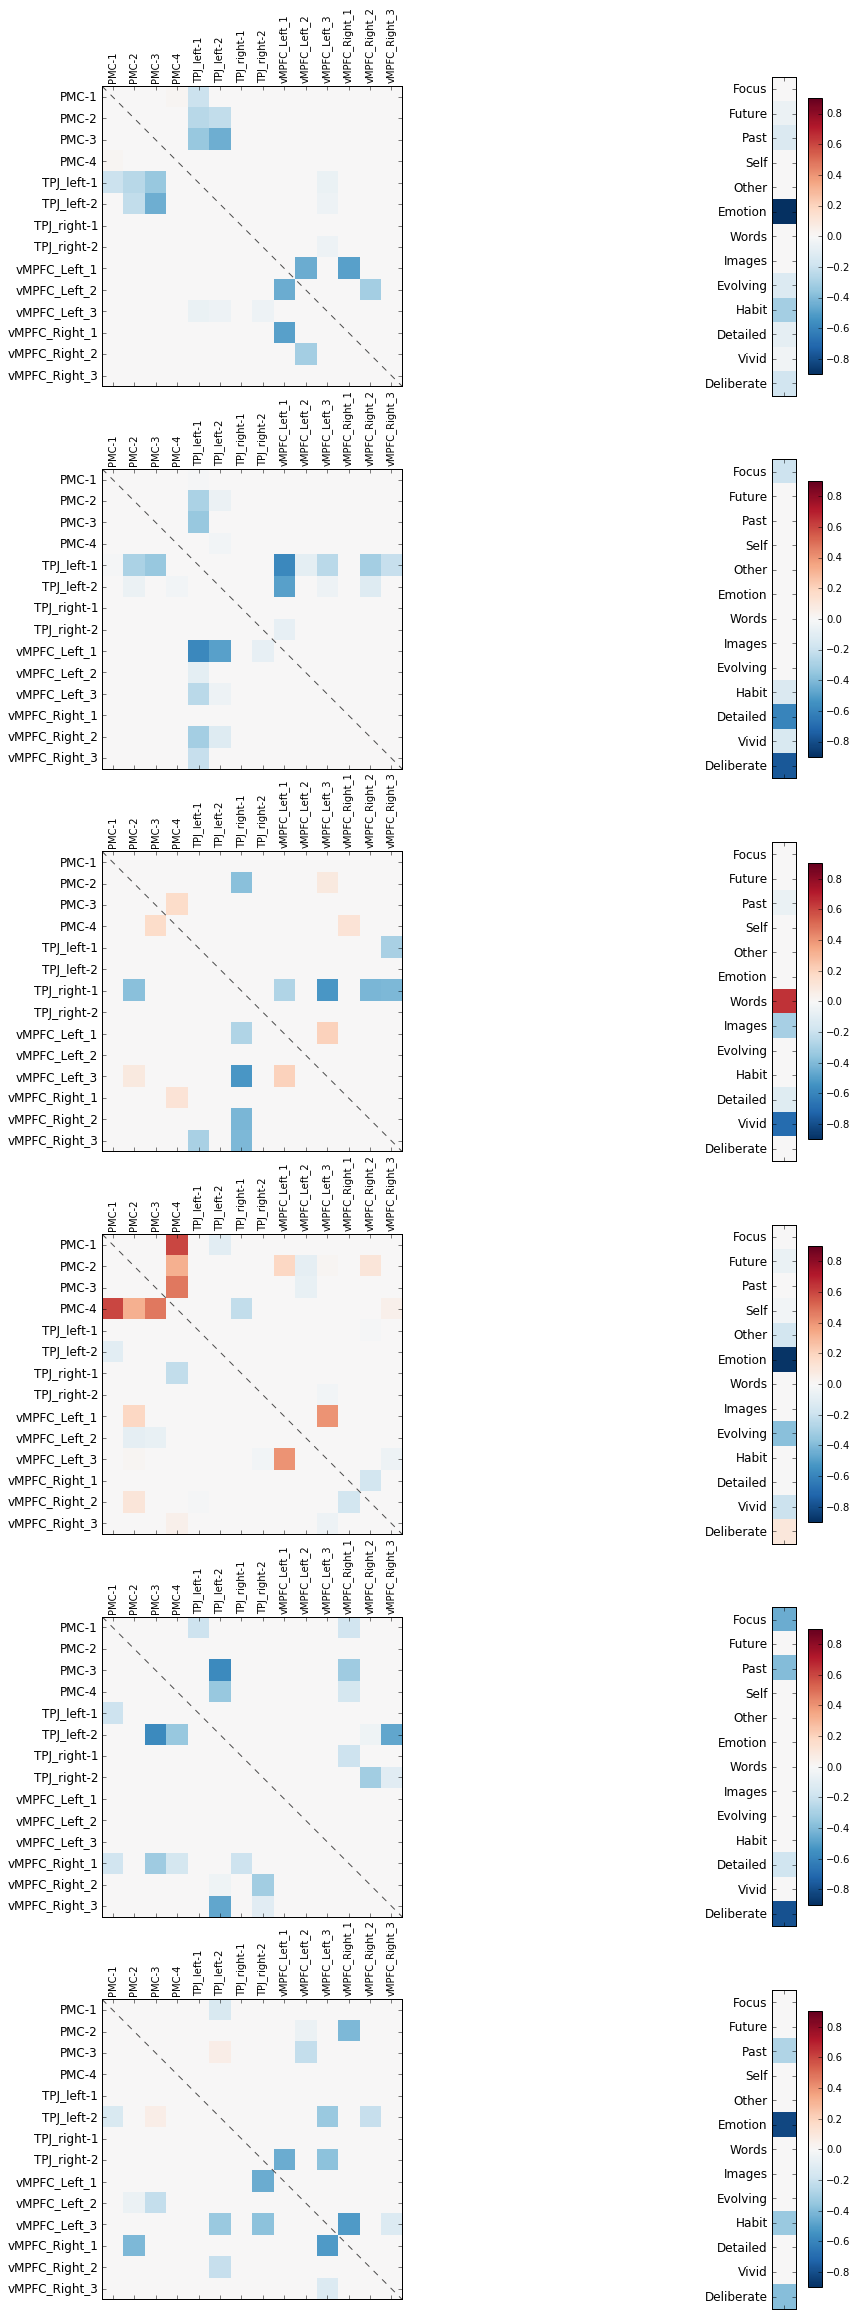

In [12]:
idx = np.triu_indices(n_areas, 1)
corr_mat = np.zeros((n_areas, n_areas, n_components))
for i in range(n_components):
    this_mat = np.zeros((n_areas, n_areas))
    this_mat[idx] = x_loadings[:, i]
    corr_mat[..., i] = this_mat + this_mat.T

plt.close('all')
fig = plt.figure(figsize=(20, 40))
# fig = plt.figure()
fig.subplots_adjust(left=0.3, right=0.8, hspace = 0.2, wspace = 0.4)
for i in range(n_components):

    ax = fig.add_subplot(n_components, 2, i*2 + 1)

    brain = ax.matshow(corr_mat[..., i], vmin=-0.9, vmax=0.9, cmap=plt.cm.RdBu_r)
    ax.set_xticks(np.arange(n_areas))
    ax.set_xticklabels(region_labels, rotation=90)
    ax.set_yticks(np.arange(n_areas))
    ax.set_yticklabels(region_labels, fontsize='large')
    ax.plot([-0.5, 13.5], [-0.5, 13.5], ls='--', c='.3')
    # cb_brain = fig.colorbar(brain, fraction=0.046, pad=0.04)

    behav_ax = fig.add_subplot(n_components, 2, (i + 1)*2)
    behav_arr = np.zeros((len(beh_keys),1))
    behav_arr.flat[:y_loadings.shape[0]] = y_loadings[:, i]
    behav = behav_ax.matshow(behav_arr, vmin=-0.9, vmax=0.9, cmap=plt.cm.RdBu_r)
    behav_ax.set_yticks(np.arange(len(beh_keys)))
    behav_ax.set_yticklabels(beh_keys, fontsize='large')
    behav_ax.set_xticklabels(' ')
    cb_behave = fig.colorbar(behav, fraction=0.046, pad=0.04)
    # fig.tight_layout()

# plt.savefig(result_corr_fn)
plt.show(fig)

Cannonical Correlation Coefficent: [ 0.308  0.353  0.357  0.308  0.366  0.243]
Confident interval: 95%
Low: [ 0.034  0.05   0.025  0.013  0.013 -0.013]
High: [ 0.508  0.522  0.508  0.517  0.495  0.5  ]


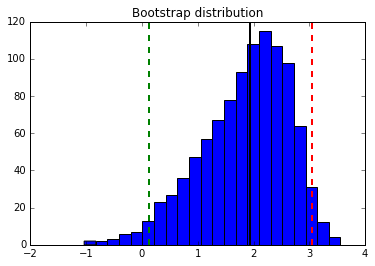

In [13]:
n_samples =1000

from numpy.random import randint
# select a random index
bootsInd = randint(X.shape[0],size=(n_samples, X.shape[0]))

for i, I in enumerate(bootsInd):
    cur_X = X[I,:]
    cur_Y = Y[I,:]
    cur_loadings, cur_cors = SCCA_r(cur_X,cur_Y, 6, penalty) # run SCCA
    if i ==0:
        corr_master = np.zeros((cur_cors.shape[0], n_samples))
    corr_master[...,i] = cur_cors 

#sort the canonical correlation score
corr_master.sort(axis=1)

# confidnece interval
alpha = 0.05
ind_low = int(n_samples*alpha/2)
ind_high = int(n_samples - n_samples*alpha/2)
ci_corr =  (corr_master[:,ind_low], corr_master[:,ind_high])
np.set_printoptions(precision=3)
print('Cannonical Correlation Coefficent: %s' %str(corr))
print('Confident interval: 95%')
print('Low: %s'%str(ci_corr[0]))
print('High: %s'%str(ci_corr[1]))

plt.hist(corr_master.sum(axis=0), bins='auto')  
plt.plot([ci_corr[0].sum(), ci_corr[0].sum()], [0, 120], '--', lw=2)
plt.plot([ci_corr[1].sum(), ci_corr[1].sum()], [0, 120], '--', lw=2)
plt.plot([corr.sum(), corr.sum()], [0, 120], 'k-', lw=2)

plt.title('Bootstrap distribution')
plt.show()